# Installing / Importing Libraries

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.stattools import adfuller,kpss
import seaborn as sns
import holidays
import datetime
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

## Data conversion

This section of the procedure implements a function that can convert a time series into supervised learning data.

In [3]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)
Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data.tail()

,Inquiries_NonStat
date,
2022-09-26,13039.00
2022-09-27,11598.00
2022-09-28,11886.00
2022-09-29,11772.00
2022-09-30,10669.00


Past 2 years data from 2020 Jan to 2022 Sept

<AxesSubplot: xlabel='date'>

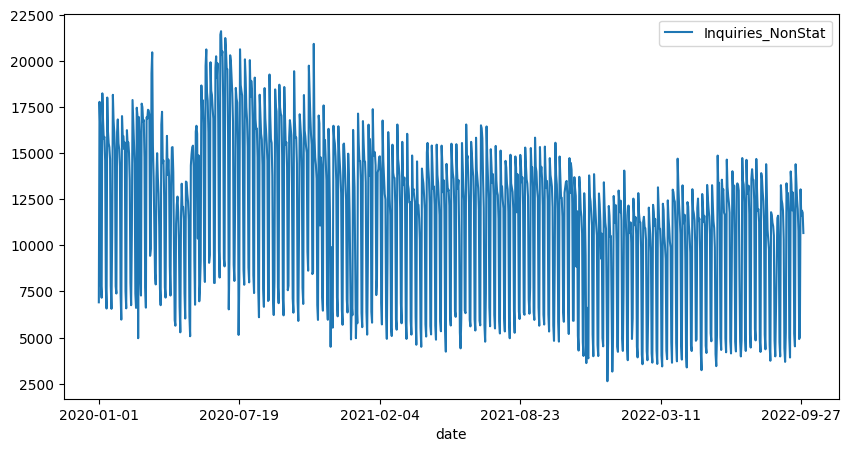

In [4]:
Daily_data.loc['2020-01-01':'2022-09-31'].plot()

## Feature Engineering

### Seasons

In [5]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

In [6]:
Daily_data.reset_index(inplace = True)
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data.set_index('date', inplace = True)

Daily_data = seasons(Daily_data)

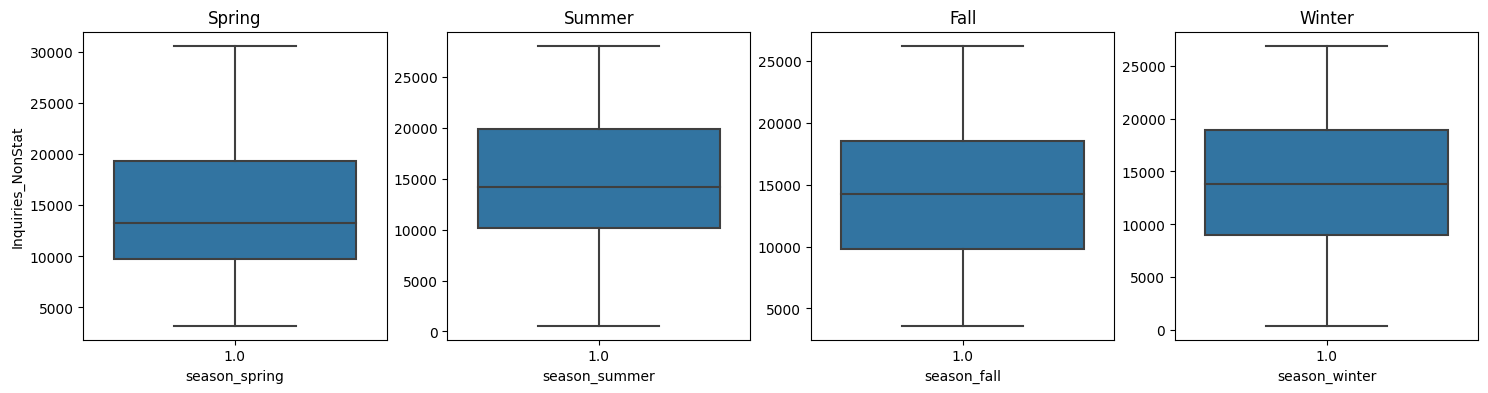

In [7]:
# Create the boxplots for seasons
# Create the figure and axis objects
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
# Create the first boxplot
sns.boxplot(x='season_spring', y='Inquiries_NonStat', data=Daily_data, ax=ax[0])
ax[0].set_title('Spring')

# Create the second boxplot
sns.boxplot(x='season_summer', y='Inquiries_NonStat', data=Daily_data, ax=ax[1])
ax[1].set_title('Summer')
ax[1].set_ylabel('')

# Create the third boxplot
sns.boxplot(x='season_fall', y='Inquiries_NonStat', data=Daily_data, ax=ax[2])
ax[2].set_title('Fall')
ax[2].set_ylabel('')
# Create the fourth boxplot
sns.boxplot(x='season_winter', y='Inquiries_NonStat', data=Daily_data, ax=ax[3])
ax[3].set_title('Winter')
ax[3].set_ylabel('')
# Show the plot
plt.show()


There is not much connection between the number of inquiries and season of the year. 

### Holidays

In [8]:
df=Daily_data
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
# Create a DataFrame of holidays

nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019,2020,2021,2022])
holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.set_index(['date'])

# Join the holidays DataFrame with the original DataFrame
df = df.join(holidays_df, on='date')
df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)
Daily_data = df

<AxesSubplot: xlabel='holiday', ylabel='Inquiries_NonStat'>

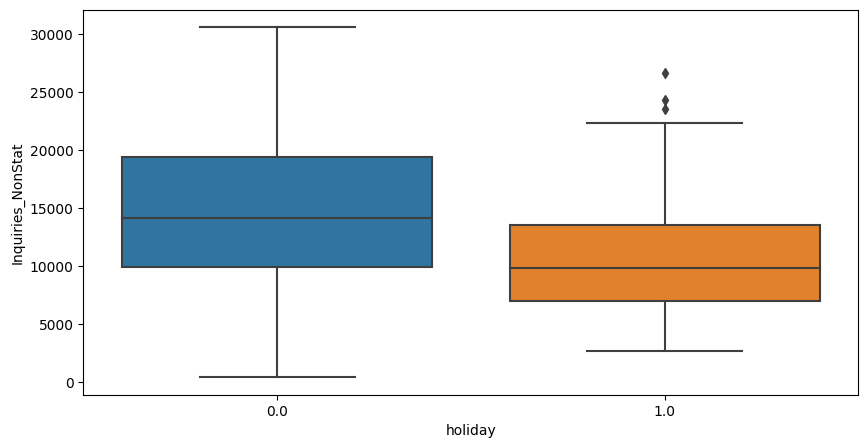

In [9]:
sns.boxplot(x='holiday', y='Inquiries_NonStat', data=Daily_data)
#ax.set_title('Holiday')

For the holiday feature, we can clearly see that there is on average a higher inquiries on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [10]:
from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox
# Correlation between holiday feature and the number of inquiries per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(Daily_data['holiday'], Daily_data['Inquiries_NonStat'])

KruskalResult(statistic=3538.5041725436877, pvalue=0.0)

### Weekdays

In [11]:
### create new feature weekday
Daily_data['weekday'] = Daily_data.index.weekday

Sunday - 6
Monday - 0
Tuesday - 1
Wednesday - 2
Thursday - 3
Friday - 4
Saturday - 5

In [12]:
### one hot encode the feature weekday
weekday_dummies = pd.get_dummies(Daily_data['weekday'], prefix='weekday')
Daily_data = Daily_data.join(weekday_dummies, how='left')
Daily_data.head(7)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,6,0,0,0,0,0,0,1
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,0,1,0,0,0,0,0,0
2017-01-03,24678.00,0.00,0.00,0.00,1.00,0.00,1,0,1,0,0,0,0,0
2017-01-04,23380.00,0.00,0.00,0.00,1.00,0.00,2,0,0,1,0,0,0,0
2017-01-05,22809.00,0.00,0.00,0.00,1.00,0.00,3,0,0,0,1,0,0,0
2017-01-06,20344.00,0.00,0.00,0.00,1.00,0.00,4,0,0,0,0,1,0,0
2017-01-07,11942.00,0.00,0.00,0.00,1.00,0.00,5,0,0,0,0,0,1,0


In [13]:
### create new feature working_day
Daily_data['working_day'] = Daily_data['weekday'].apply(lambda x: 0 if x >= 5 else 1)
Daily_data['working_day'] = Daily_data[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)
Daily_data

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day
date,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,6,0,0,0,0,0,0,1,0.00
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,0,1,0,0,0,0,0,0,0.00
2017-01-03,24678.00,0.00,0.00,0.00,1.00,0.00,1,0,1,0,0,0,0,0,1.00
2017-01-04,23380.00,0.00,0.00,0.00,1.00,0.00,2,0,0,1,0,0,0,0,1.00
2017-01-05,22809.00,0.00,0.00,0.00,1.00,0.00,3,0,0,0,1,0,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.00,0.00,0.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,1.00
2022-09-27,11598.00,0.00,0.00,1.00,0.00,0.00,1,0,1,0,0,0,0,0,1.00
2022-09-28,11886.00,0.00,0.00,1.00,0.00,0.00,2,0,0,1,0,0,0,0,1.00


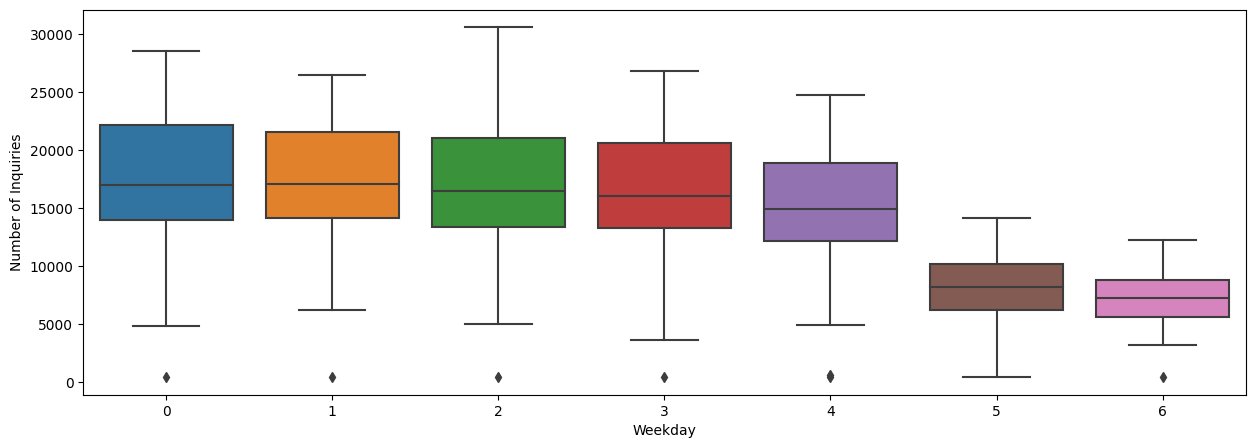

In [14]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sns.boxplot(data = Daily_data, x = 'weekday', y = 'Inquiries_NonStat')
plt.xlabel('Weekday')
plt.ylabel('Number of Inquiries');

In [15]:
# Correlation between weekday feature and the number of inquiries per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(Daily_data['weekday'], Daily_data['Inquiries_NonStat'])

PearsonRResult(statistic=-0.6424858015009073, pvalue=1.0337213475969245e-244)

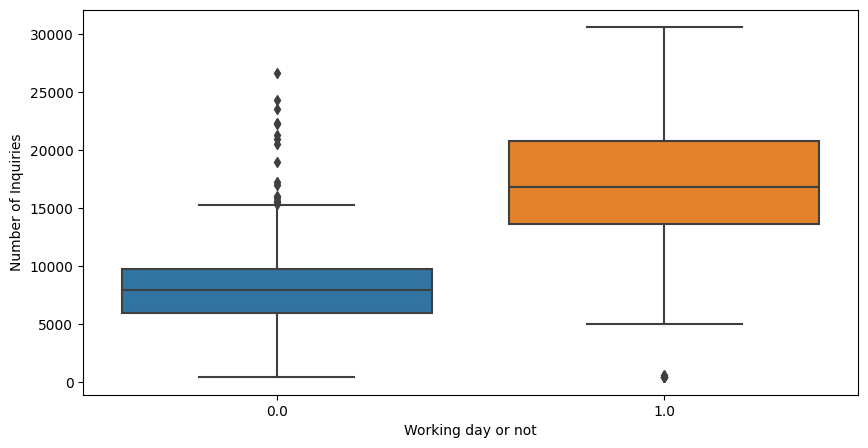

In [16]:
# plotting workday feature in boxplot against the count of customers
sns.boxplot(data = Daily_data, x = 'working_day', y = 'Inquiries_NonStat')
plt.xlabel('Working day or not')
plt.ylabel('Number of Inquiries');

In [17]:
# Correlation between working_day feature and the number of Inquiries per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(Daily_data['working_day'], Daily_data['Inquiries_NonStat'])

KruskalResult(statistic=3290.489700761312, pvalue=0.0)

In [18]:
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day
date,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,6,0,0,0,0,0,0,1,0.00
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,0,1,0,0,0,0,0,0,0.00


### Month

In [19]:
### create new feature weekday
Daily_data['Month'] = Daily_data.index.month

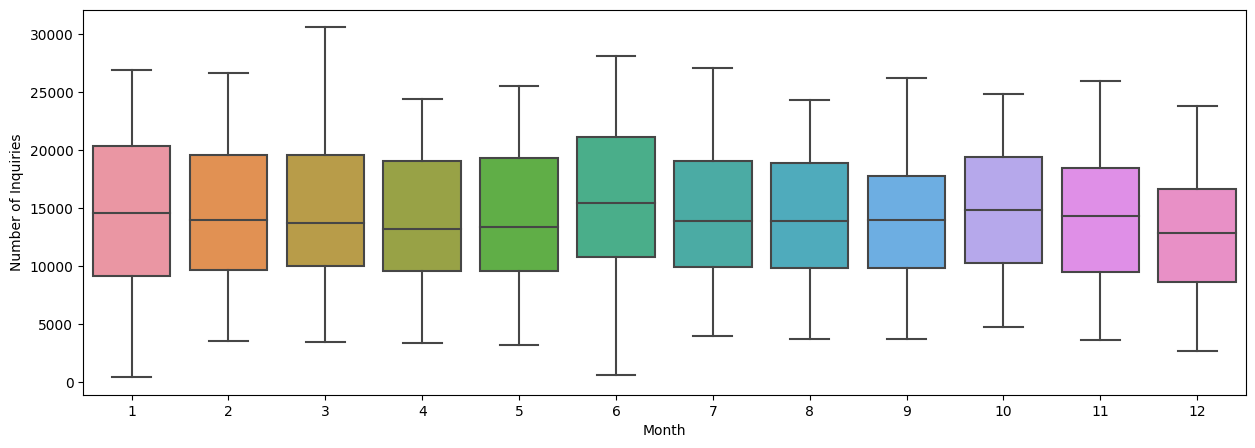

In [20]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sns.boxplot(data = Daily_data, x = 'Month', y = 'Inquiries_NonStat')
plt.xlabel('Month')
plt.ylabel('Number of Inquiries');

In [21]:
### one hot encode the feature month
Month_dummies = pd.get_dummies(Daily_data['Month'], prefix='Month')
Daily_data = Daily_data.join(Month_dummies, how='left')
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday,weekday_0,weekday_1,weekday_2,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
pearsonr(Daily_data['Month'], Daily_data['Inquiries_NonStat'])

PearsonRResult(statistic=-0.02992057947891609, pvalue=0.17059423605768032)

The correlation between Month and Seasons is high and I am removing Monthly dummy variables as it also increases sparsity in the data

### PACF to determine optimal lag for total_cust target label

Details on the process can be found here and here. We want to avoid using variables with multicolinearity and thus, we do not want to use too many lag variables.

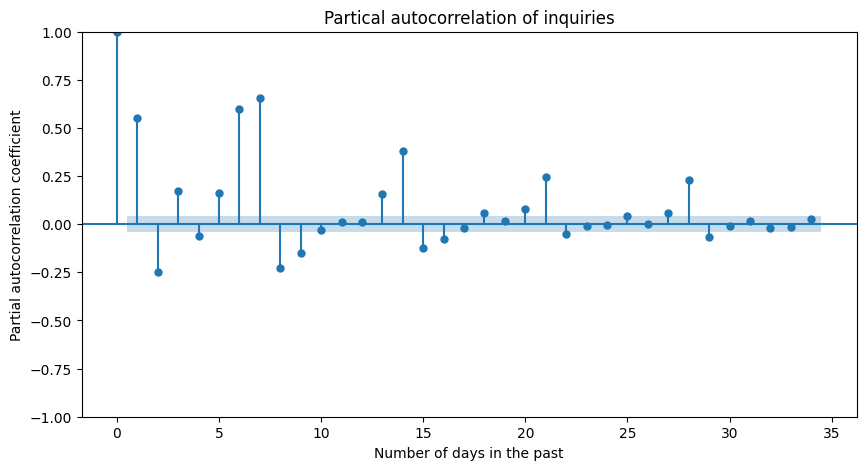

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(Daily_data['Inquiries_NonStat'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

AR(7) --> High degree of autocorrelation between adjacent (lag = 7) and near-adjacent (lag = 6 & 1) observations in PACF plot https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c#:~:text=The%20difference%20between%20ACF%20and,indicator%20of%20the%20significance%20threshold.

Rolling mean of 7 days from the above plot

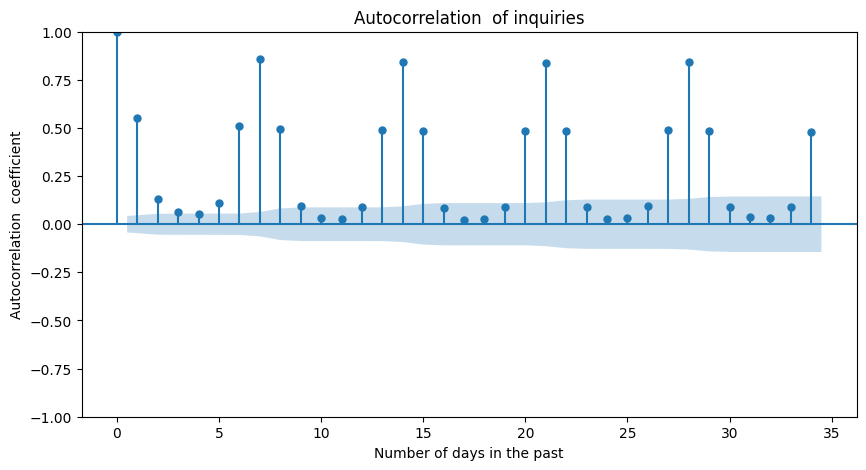

In [24]:
plot_acf(Daily_data['Inquiries_NonStat'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.
High degree of autocorrelation between adjacent (lag = 7) in ACF plot

Lag 1,6,7,8

In [25]:
# get list for all correlations between a feature and total_cust with different rolling means

def best_window(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
        #print('window size: ', i, 'corr: ', corr)
    # get the optimal window size for rolling mean between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

# get list for all correlations between a feature and total_cust with different rolling standard deviations

def best_window_std(x, y, max_window):
    corr_temp_cust = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
        
    # get the optimal window size for rolling std between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [26]:
# get the optimal window for rolling std for Inquiries_NonStat
print(best_window_std(Daily_data['Inquiries_NonStat'], Daily_data['Inquiries_NonStat'], 30))

# get the correlation for window size determined by Inquiries_NonStat
cust_mean = Daily_data['Inquiries_NonStat'].rolling(7).std()[6:-1]
pearsonr(cust_mean, Daily_data['Inquiries_NonStat'][7:])

{4: 0.70887593139994, 1: 0.025517592107480194}


PearsonRResult(statistic=0.43997505091590416, pvalue=9.01933594427949e-100)

In [27]:
# get the optimal window for rolling std for Inquiries_NonStat
print(best_window(Daily_data['Inquiries_NonStat'], Daily_data['Inquiries_NonStat'], 30))

# get the correlation for window size determined by Inquiries_NonStat
cust_mean = Daily_data['Inquiries_NonStat'].rolling(7).mean()[6:-1]
pearsonr(cust_mean, Daily_data['Inquiries_NonStat'][7:])

{8: 0.5841399213922005, 5: 0.28228744478784407}


PearsonRResult(statistic=0.5516196684133285, pvalue=6.933685230553338e-167)

By correlation between mean of window size ranging from 2 to 30, and actual timestamp, window size of 8 has the highest correlation

### Adding (Mean of 7/8 days) and (std of 4 days) rolling window size

In [28]:
# Calculate the mean and standard deviation of a rolling window size 8
Daily_data['Inq_mean_8'] = Daily_data['Inquiries_NonStat'].rolling(window=8).mean()
Daily_data['Inq_mean_7'] = Daily_data['Inquiries_NonStat'].rolling(window=7).mean()
Daily_data['Inq_std_4'] = Daily_data['Inquiries_NonStat'].rolling(window=4).std()

In [29]:
# add the value from t-1
Daily_data['Inq_1'] = Daily_data['Inquiries_NonStat'].shift(1)
Daily_data['Inq_2'] = Daily_data['Inquiries_NonStat'].shift(2)
Daily_data['Inq_3'] = Daily_data['Inquiries_NonStat'].shift(3)
Daily_data['Inq_4'] = Daily_data['Inquiries_NonStat'].shift(4)
Daily_data['Inq_5'] = Daily_data['Inquiries_NonStat'].shift(5)
Daily_data['Inq_6'] = Daily_data['Inquiries_NonStat'].shift(6)
Daily_data['Inq_7'] = Daily_data['Inquiries_NonStat'].shift(7)
Daily_data['Inq_8'] = Daily_data['Inquiries_NonStat'].shift(8)
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday,weekday_0,weekday_1,weekday_2,...,Inq_mean_7,Inq_std_4,Inq_1,Inq_2,Inq_3,Inq_4,Inq_5,Inq_6,Inq_7,Inq_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,6,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,0,1,0,0,...,NaN,NaN,7574.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Correlation Matrix

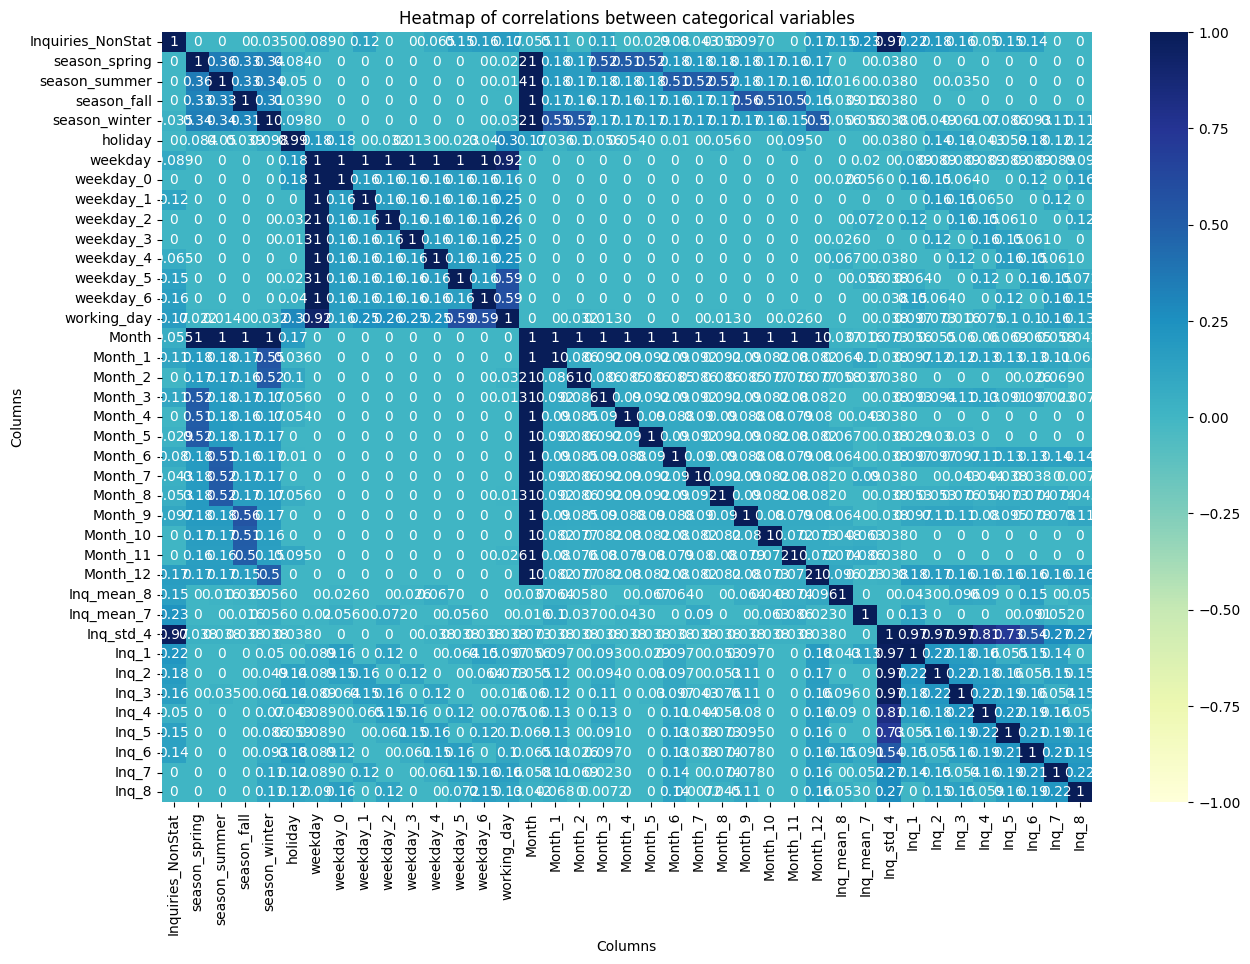

In [30]:
# drop any non-categorical variables
Daily_data_corr_cat = Daily_data#.drop(columns=['weekday', 'Inquiries_NonStat'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

## Feature Selection
Based on the EDA above, I will choose the following features

holiday: t0

weekdays: each day at t0
months: each day at t0

workingday: t0

seasons: t0

inq: t-1 to t-7
inq: rolling std for 4 days
inq: rolling mean for 8 days

# Data Preparation

3.1. Dropping unnecessary columns
I am only going to remove any columns which I no longer need and split the dataframes into X and y.

In [40]:
final_df  = Daily_data.drop(columns=['weekday', 'Month']).fillna(0)
final_df.columns

Index(['Inquiries_NonStat', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'working_day',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Inq_mean_8', 'Inq_mean_7', 'Inq_std_4', 'Inq_1', 'Inq_2', 'Inq_3',
       'Inq_4', 'Inq_5', 'Inq_6', 'Inq_7', 'Inq_8'],
      dtype='object')

# Model

### Models with Lazy Predict

In [41]:
final_df.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday_0,weekday_1,weekday_2,weekday_3,...,Inq_mean_7,Inq_std_4,Inq_1,Inq_2,Inq_3,Inq_4,Inq_5,Inq_6,Inq_7,Inq_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,1,0,0,0,...,0.00,0.00,7574.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [42]:
# Split the data into training, validation, and test sets
train_df = final_df[:int(len(final_df)*0.7)]                       # 70% train set
val_df = final_df[int(len(final_df)*0.7):int(len(final_df)*0.9)]   # 20% validation set
test_df = final_df[int(len(final_df)*0.9):]                        # 10% test set


In [43]:
log_final_df  = final_df
log_final_df.columns

Index(['Inquiries_NonStat', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'working_day',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'Inq_mean_8', 'Inq_mean_7', 'Inq_std_4', 'Inq_1', 'Inq_2', 'Inq_3',
       'Inq_4', 'Inq_5', 'Inq_6', 'Inq_7', 'Inq_8'],
      dtype='object')

In [44]:
# assigning X and y
y = log_final_df['Inquiries_NonStat']
X = log_final_df.drop(columns=['Inquiries_NonStat'])

# getting the start time
start_time = datetime.datetime.now()

X, y = shuffle(X, y, random_state=13)
X = X.astype(np.float32)
train_offset = int(X.shape[0] * 0.7)
val_offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:train_offset], y[:train_offset]
X_test, y_test = X[train_offset:val_offset], y[train_offset:val_offset]

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

# get final time
end_time = datetime.datetime.now()
print('Total running time of naive predictor:', (end_time - start_time).total_seconds())

100%|██████████| 42/42 [02:36<00:00,  3.73s/it]

Total running time of naive predictor: 156.547062


In [45]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,1.00,1.00,0.01,0.03
PassiveAggressiveRegressor,1.00,1.00,49.48,0.10
HuberRegressor,0.99,0.99,545.89,0.09
XGBRegressor,0.95,0.95,1255.00,0.21
GradientBoostingRegressor,0.94,0.94,1406.54,0.42
ExtraTreesRegressor,0.94,0.94,1412.82,0.79
BaggingRegressor,0.94,0.94,1414.98,0.13
RandomForestRegressor,0.93,0.94,1467.67,1.07
HistGradientBoostingRegressor,0.93,0.93,1510.01,0.74


### Cross  Validation Random Regressor

In [51]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)

In [52]:
# Initialize models
random_search_model = RandomForestRegressor(random_state=0)
grid_search_model   = RandomForestRegressor(random_state=0)

In [99]:
# Set up the grid to pick hyperparameters from:
param_dist = {"n_estimators": [10, 100, 500, 1000],
              "max_depth": [3, 5, 7, None],
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 10),
              "bootstrap": [True, False]}

In [100]:
# Create the randomized search object
random_search = RandomizedSearchCV(random_search_model, param_distributions=param_dist, 
                                   n_iter=500, cv=tscv, 
                                   scoring="neg_mean_squared_error", 
                                   random_state=0)

In [101]:
# Fit the model to the data
y = log_final_df['Inquiries_NonStat']
X = log_final_df.drop(columns=['Inquiries_NonStat','Inquiries_NonStat'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.3, shuffle = False, random_state = 0)


# Fit the randomized search on the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

In [102]:
# Get the best model
best_model = random_search.best_estimator_
print(best_model)

RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=0)


In [103]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'],
                                  max_depth=random_search.best_params_['max_depth'],
                                  min_samples_split=random_search.best_params_['min_samples_split'],
                                  min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
y_train_pred = best_rfr.predict(X_train)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
y_test_pred = best_rfr.predict(X_test)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


Train MAE:  338.68978578416153
Train RMSE: 618.0171125529502
Test MAE:  1120.0239786223822
Test RMSE: 1441.7487693354421


Model underfits the data with Train MAE:  274.7613873383254
Train RMSE: 507.55758604340883
Test MAE:  775.2210476190477
Test RMSE: 1383.255437729972

Trying to increase max_depth 

In [185]:
train_rf = pd.DataFrame()
train_rf['train'] = y_train
train_rf['train_pred'] = y_train_pred
predictions_rf = pd.DataFrame()
predictions_rf['y_test'] = y_test
new_plot['y_test_pred'] = y_test_pred

## Prediction INterval

In [130]:
new_plot['residuals'] = predictions_rf['y_test'] - predictions_rf['y_test_pred']

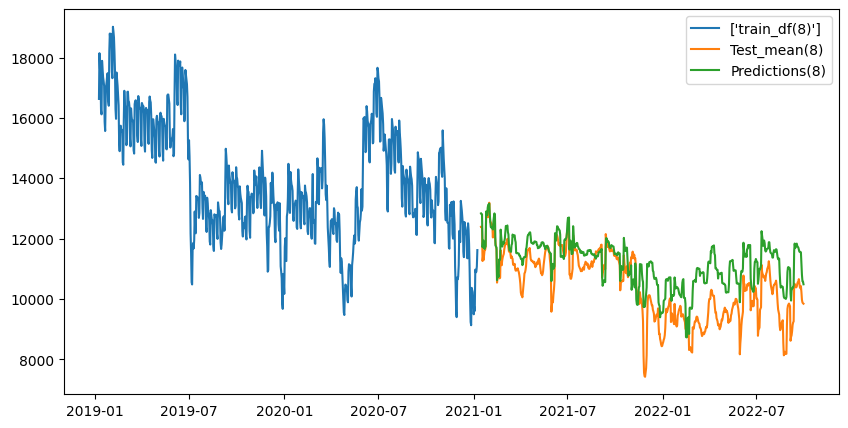

In [176]:
#plt.plot(predictions_rf.sort_index(), label=['Test set','Predictions'])
plt.plot(train_df[['Inquiries_NonStat']][train_df.index.year >=2019].sort_index().rolling(8).mean(), label=['train_df(8)'])
plt.plot(predictions_rf[['y_test','y_test_pred']].sort_index().rolling(7).mean(), label=['Test_mean(8)','Predictions(8)'])
#plt.plot(predictions_rf['residuals'], label = 'residual')
plt.legend();

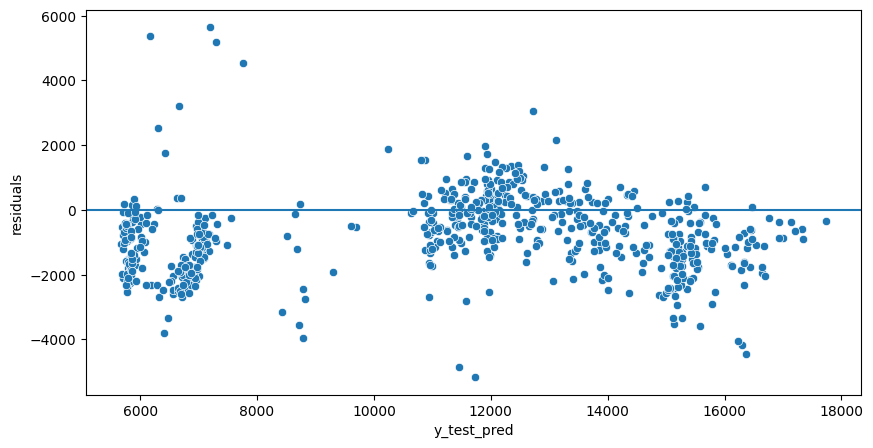

In [138]:
sns.scatterplot(data=predictions_rf, x="y_test_pred", y="residuals")
plt.axhline(y=0)

In a normal distribution, 95% of data points fall within 1.96 standard deviations of the mean, so we multiply 1.96 by the RMSFE to get get the prediction interval size.

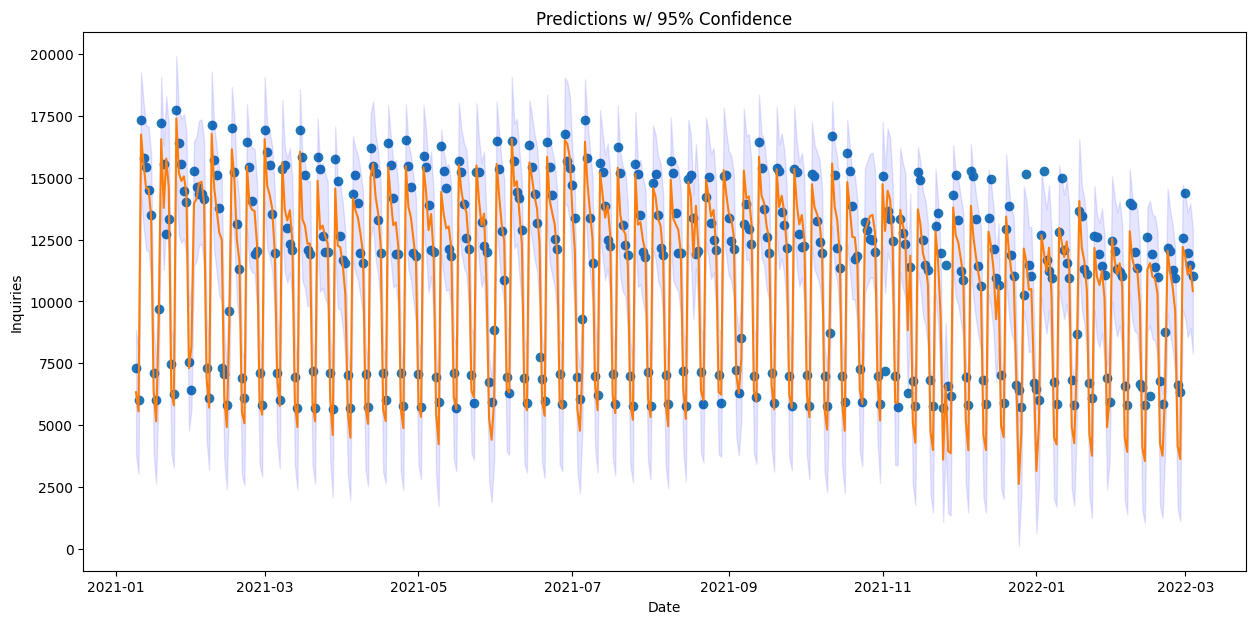

In [155]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf[:len(val_df)]['residuals'] ]) / len(predictions_rf[:len(val_df)]['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(val_df.index, val_df['Inquiries_NonStat'], color='#fc7d0b', label='Valid')
ax.scatter(val_df.index, predictions_rf[:len(val_df)]['y_test_pred'])
ax.fill_between(val_df.index, (val_df['Inquiries_NonStat']-band_size), (val_df['Inquiries_NonStat']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.show()

In [ ]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf[:len(val_df)]['residuals'] ]) / len(predictions_rf[:len(val_df)]['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
#plt.plot(predictions_rf.sort_index(), label=['Test set','Predictions'])
ax.plot(train_df[['Inquiries_NonStat']][train_df.index.year >=2019].sort_index().rolling(8).mean(), label=['train_df(8)'])
ax.plot(predictions_rf[['y_test','y_test_pred']].sort_index().rolling(7).mean(), label=['Test_mean(8)','Predictions(8)'])
plt.plot(predictions_rf['residuals'], label = 'residual')
#ax.plot(train_df.index, train_df['Inquiries_NonStat'], color='#111000', label='Train')
ax.plot(val_df.index, val_df['Inquiries_NonStat'], color='#117000', label='Valid')
ax.plot(test_df.index, test_df['Inquiries_NonStat'], color='#117000', label='Test')
ax.plot(val_df.index, predictions_rf[:len(val_df)]['y_test_pred'], label='Prediction')
ax.scatter(val_df.index, predictions_rf[:len(val_df)]['y_test_pred'])
ax.fill_between(val_df.index, (val_df['Inquiries_NonStat']-band_size), (val_df['Inquiries_NonStat']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.show()

## Feature Importance

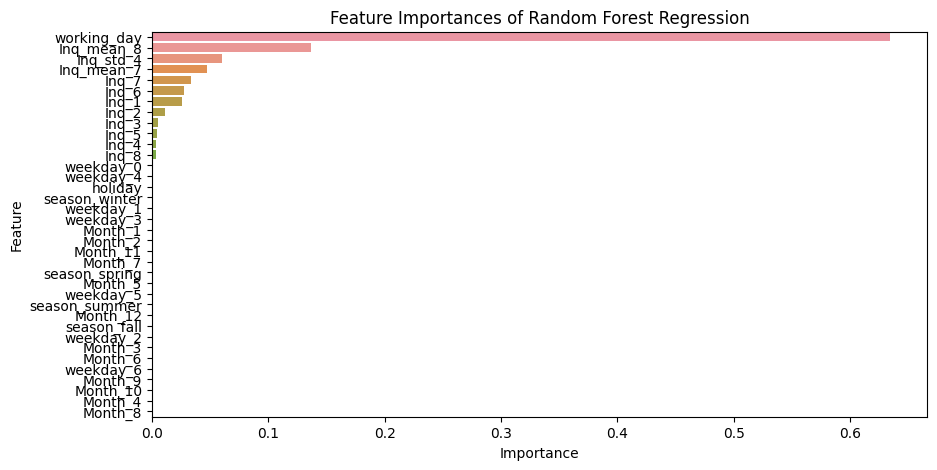

In [117]:
# Access the feature importances
importances = best_rfr.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [118]:
log_final_df.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday_0,weekday_1,weekday_2,weekday_3,...,Inq_mean_7,Inq_std_4,Inq_1,Inq_2,Inq_3,Inq_4,Inq_5,Inq_6,Inq_7,Inq_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,1,0,0,0,...,0.00,0.00,7574.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Saving & loading model

In [62]:
import joblib

filename = "C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/03-models/RF.joblib"
joblib.dump(best_rfr, filename)

['C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/03-models/RF.joblib']

In [63]:
best_rfr = joblib.load(filename)
best_rfr

RandomForestRegressor(n_estimators=1000, random_state=0)

# Feature Selection

Removing less important features

In [200]:
#sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
less_important_featuresList = list(feature_importances[feature_importances['Importance']<=0.01]['Feature'])

In [188]:
final_df.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,holiday,weekday_0,weekday_1,weekday_2,weekday_3,...,Inq_mean_7,Inq_std_4,Inq_1,Inq_2,Inq_3,Inq_4,Inq_5,Inq_6,Inq_7,Inq_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0.00,0.00,0.00,1.00,1.00,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01-02,13189.00,0.00,0.00,0.00,1.00,1.00,1,0,0,0,...,0.00,0.00,7574.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [201]:
feature_removed_df  = final_df.drop(columns=less_important_featuresList).fillna(0)
feature_removed_df.columns# Split the data into training, validation, and test sets

Index(['Inquiries_NonStat', 'working_day', 'Inq_mean_8', 'Inq_mean_7',
       'Inq_std_4', 'Inq_1', 'Inq_2', 'Inq_6', 'Inq_7'],
      dtype='object')

In [208]:
train_f_df = feature_removed_df[:int(len(feature_removed_df)*0.7)]                       # 70% train set
#val_f_df = feature_removed_df[int(len(feature_removed_df)*0.7):int(len(feature_removed_df)*0.9)]   # 20% validation set
test_f_df = feature_removed_df[int(len(feature_removed_df)*0.7):]    

In [207]:
# Fit the model to the data
X_train_f_df = train_f_df.drop(columns=['Inquiries_NonStat'])
y_train_f_df = train_f_df['Inquiries_NonStat']


# Fit the randomized search on the data
random_search.fit(X_train_f_df, y_train_f_df)

# Get the best parameters
fs_best_params = random_search.best_params_
print(fs_best_params)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}


In [210]:
# use the best hyperparameters to create the final Random Forest Regressor model
fs_best_rfr = RandomForestRegressor(n_estimators=fs_best_params['n_estimators'],
                                  max_depth=fs_best_params['max_depth'],
                                  min_samples_split=fs_best_params['min_samples_split'],
                                  min_samples_leaf=fs_best_params['min_samples_leaf'],
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
fs_best_rfr.fit(X_train_f_df, y_train_f_df)

# use the final Random Forest Regressor model to make predictions on the test set
fs_train_pred = fs_best_rfr.predict(X_train_f_df)

# calculate the mean squared error of the predictions
fs_train_mae = mean_absolute_error(y_train_f_df, fs_train_pred)
fs_train_rmse = np.sqrt(mean_squared_error(y_train_f_df, fs_train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)


# use the final Random Forest Regressor model to make predictions on the test set
X_test_f = test_f_df.drop(columns=['Inquiries_NonStat'])
y_test_f = test_f_df['Inquiries_NonStat']
fs_test_pred = fs_best_rfr.predict(X_test_f)

# calculate the mean squared error of the predictions
fs_test_mae = mean_absolute_error(y_test_f, fs_test_pred)
fs_test_rmse = np.sqrt(mean_squared_error(y_test_f, fs_test_pred))
print("Test MAE: ", fs_test_mae)
print('Test RMSE:', fs_test_rmse)


Train MAE:  338.68978578416153
Train RMSE: 618.0171125529502
Test MAE:  1124.6648209805267
Test RMSE: 1451.2347262944181


Adding to previous datasets

### Feature Importance

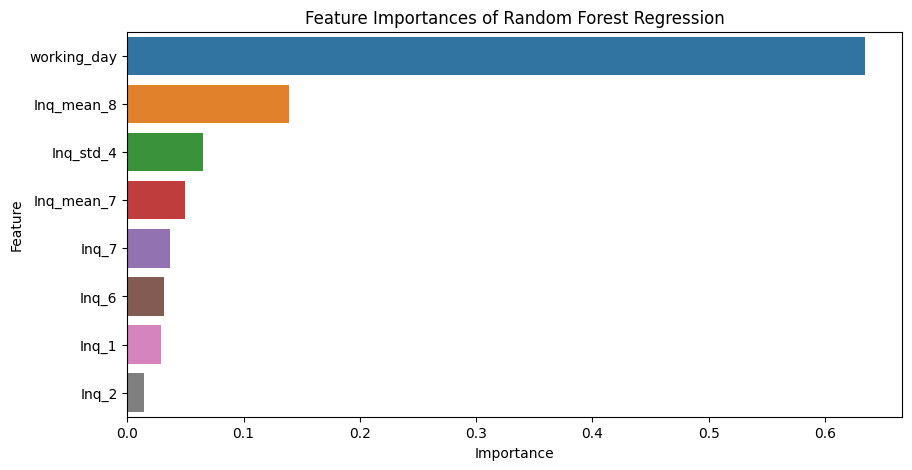

In [211]:
# Access the feature importances
fs_importances = fs_best_rfr.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train_f_df.columns, 'Importance': fs_importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()

## Prediction Intervals

In [212]:
train_rf['fs_train_pred'] = fs_train_pred
predictions_rf['fs_test_pred'] = fs_test_pred

In [213]:
predictions_rf['fs_residuals'] = predictions_rf['y_test'] - predictions_rf['fs_test_pred']

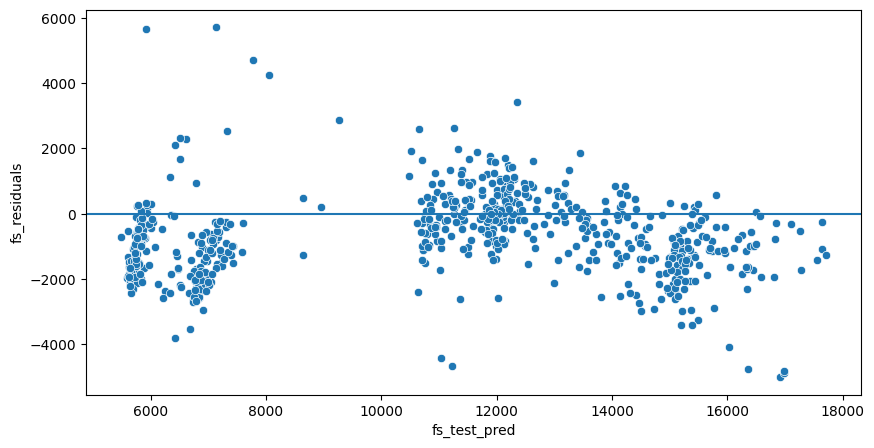

In [215]:
#sns.scatterplot(data=predictions_rf, x="y_test_pred", y="residuals")
sns.scatterplot(data=predictions_rf, x="fs_test_pred", y="fs_residuals")
plt.axhline(y=0)

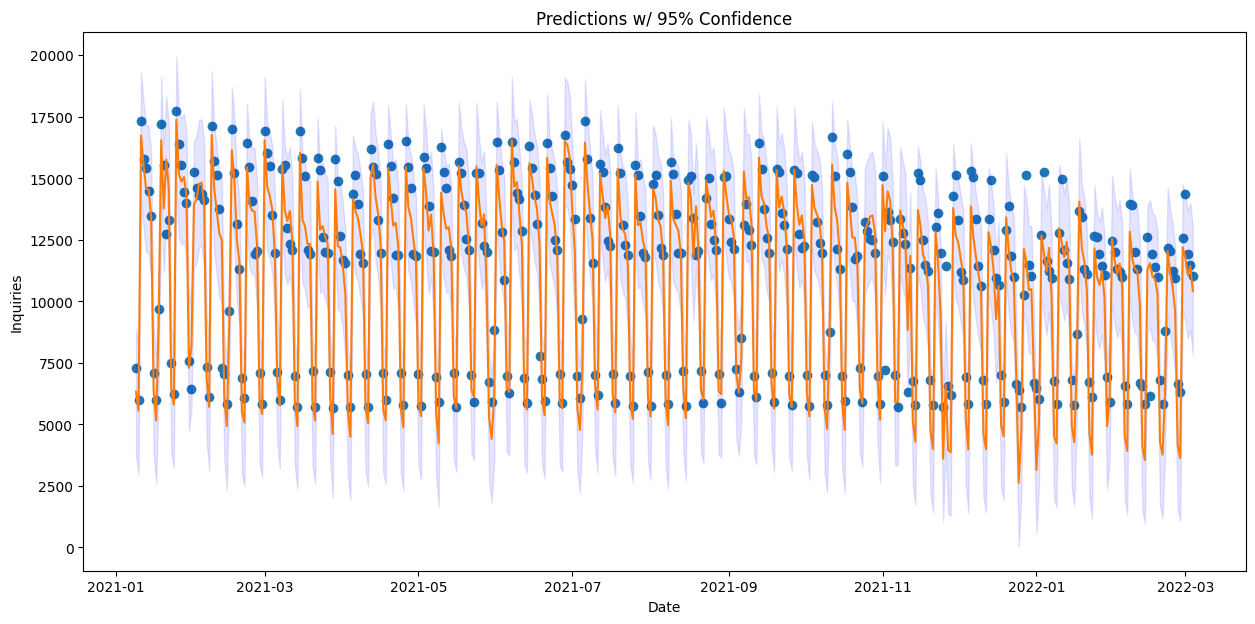

In [218]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf[:len(val_df)]['fs_residuals'] ]) / len(predictions_rf[:len(val_df)]['fs_residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(val_df.index, val_df['Inquiries_NonStat'], color='#fc7d0b', label='Valid')
ax.scatter(val_df.index, predictions_rf[:len(val_df)]['y_test_pred'])
ax.fill_between(val_df.index, (val_df['Inquiries_NonStat']-band_size), (val_df['Inquiries_NonStat']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.show()

# Prediction per weekdays

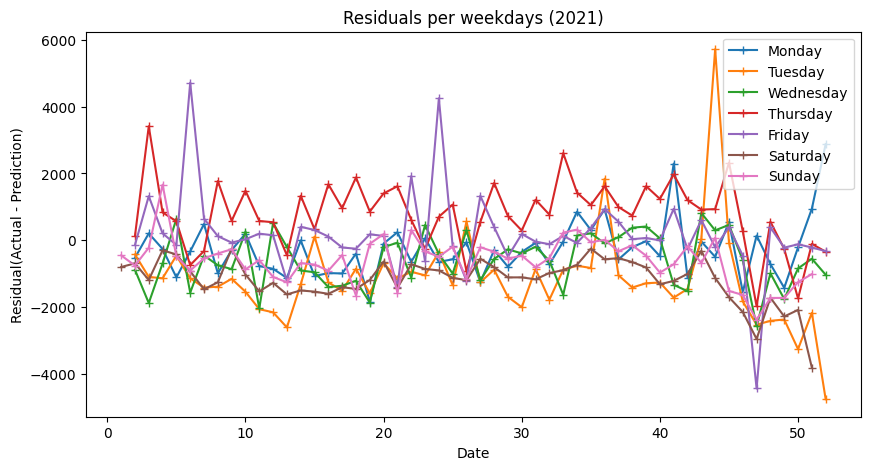

In [279]:
predictions_rf['weekday'] = predictions_rf.index.weekday
predictions_rf['weekofyear'] = predictions_rf.index.weekofyear
predictions_rf['year'] = predictions_rf.index.year 
new_plot = predictions_rf.loc[predictions_rf['year']==2021]
plt.title('Residuals per weekdays (2021)')
predictions_rf.sort_values(by=['year','weekofyear'])
plt.plot(new_plot.loc[new_plot['weekday']==0][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==0][:105][['fs_residuals']],label='Monday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==1][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==1][:105][['fs_residuals']],label='Tuesday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==2][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==2][:105][['fs_residuals']],label='Wednesday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==3][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==3][:105][['fs_residuals']],label='Thursday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==4][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==4][:105][['fs_residuals']],label='Friday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==5][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==5][:105][['fs_residuals']],label='Saturday',marker='+')
plt.plot(new_plot.loc[new_plot['weekday']==6][:105][['weekofyear']],new_plot.loc[new_plot['weekday']==6][:105][['fs_residuals']],label='Sunday',marker='+')
plt.xlabel('Date')
plt.ylabel('Residual(Actual - Prediction)')
plt.legend()

Text(0.5, 1.0, 'Sunday')

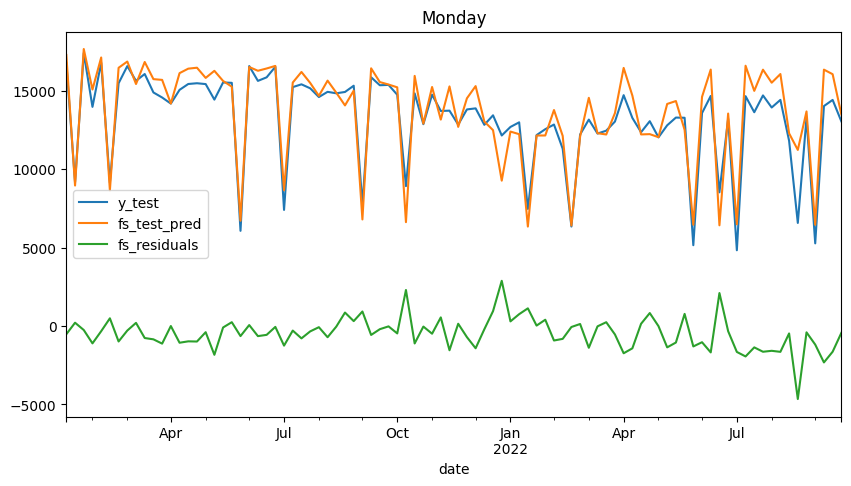

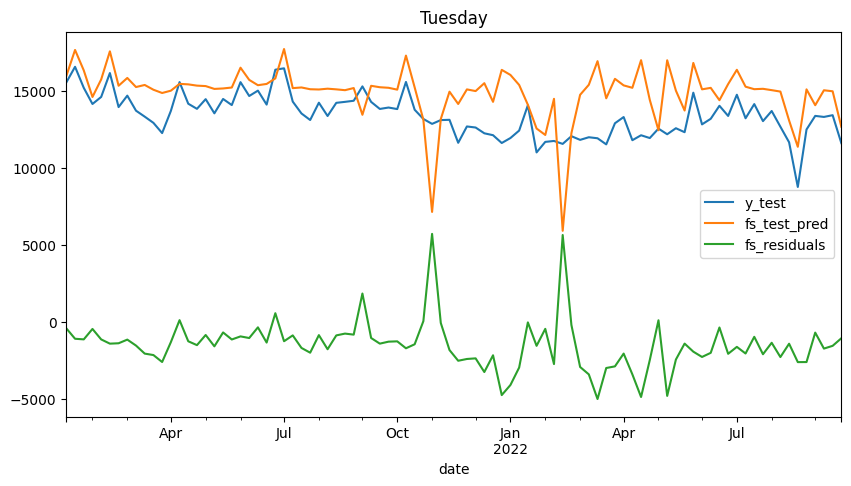

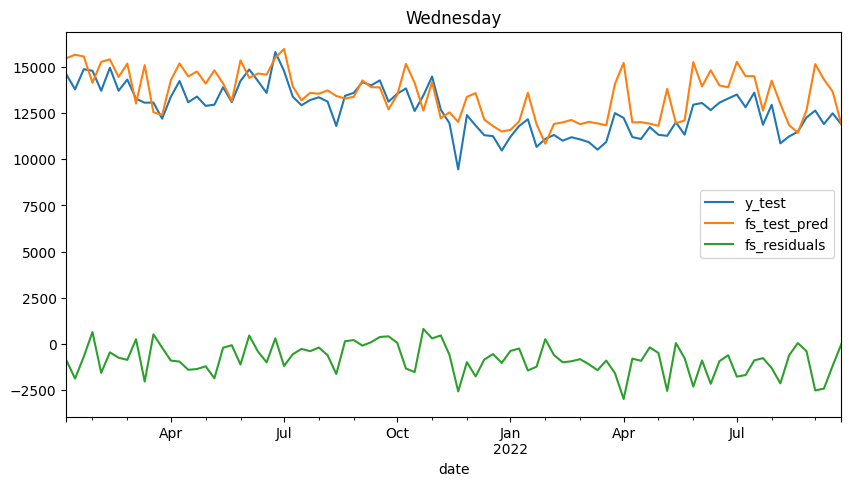

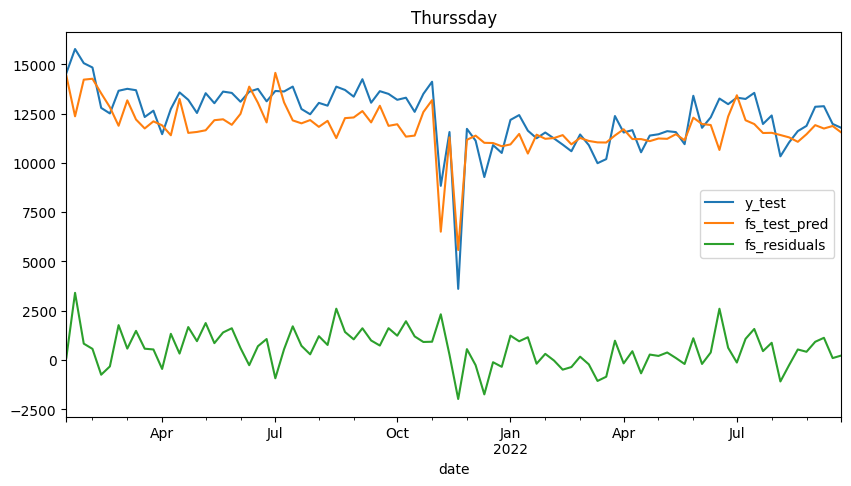

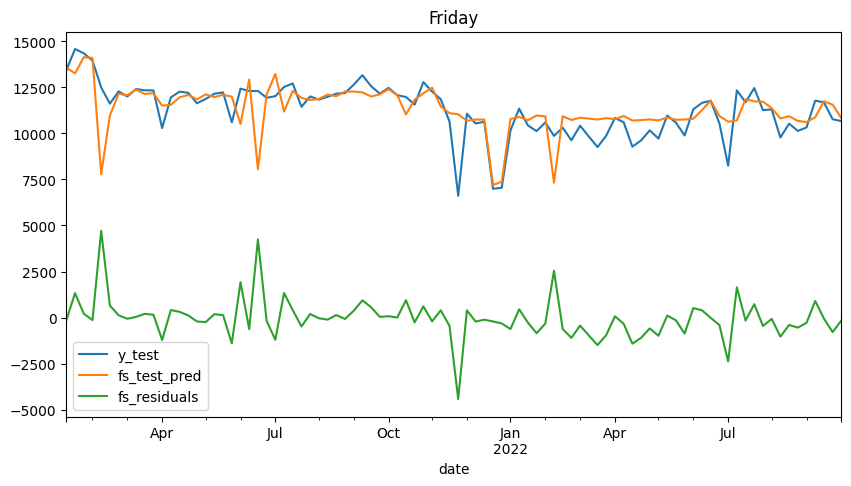

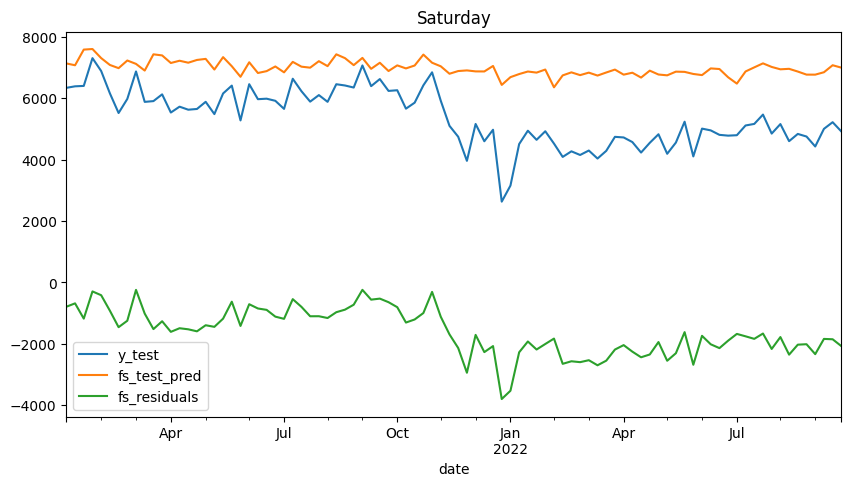

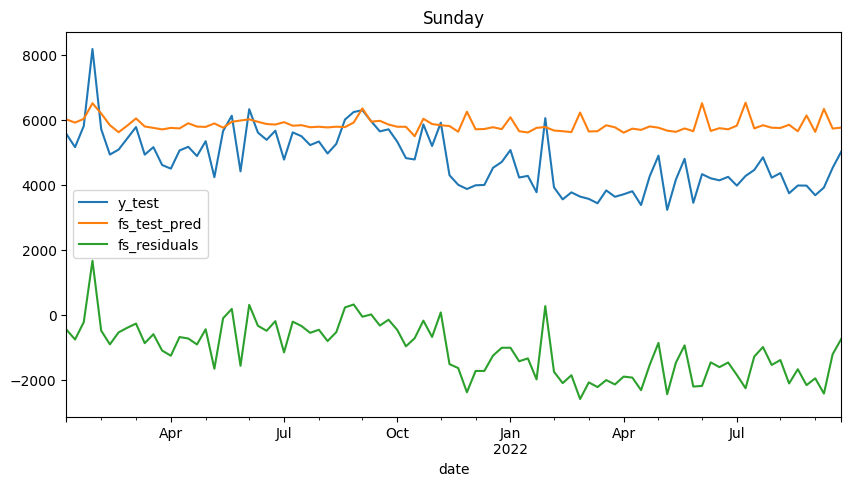

In [282]:
predictions_rf['weekday'] = predictions_rf.index.weekday
predictions_rf.loc[predictions_rf['weekday']==0][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Monday')
plt.title('Monday')
predictions_rf.loc[predictions_rf['weekday']==1][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Tuesday')
plt.title('Tuesday')
predictions_rf.loc[predictions_rf['weekday']==2][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Wednesday')
plt.title('Wednesday')
predictions_rf.loc[predictions_rf['weekday']==3][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Thursday')
plt.title('Thurssday')
predictions_rf.loc[predictions_rf['weekday']==4][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Friday')
plt.title('Friday')
predictions_rf.loc[predictions_rf['weekday']==5][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Saturday')
plt.title('Saturday')
predictions_rf.loc[predictions_rf['weekday']==6][:105][['y_test', 'fs_test_pred', 'fs_residuals']].plot(label='Sunday')
plt.title('Sunday')
